# Exercise: Random walk

## Adapted from the TALENT course on Learning from Data: Bayesian Methods and Machine Learning
### York, UK, June 10-28, 2019 

The original notebook was by Christian Forssen.

The second part of this exercise is inspired by the post ["MCMC sampling for dummies"](https://twiecki.io/blog/2015/11/10/mcmc-sampling/) in the excellent blog ["While my MCMC gently samples"](https://twiecki.io/) by Thomas Wiecki.

### Import of modules

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Not really needed, but nicer plots
import seaborn as sns
sns.set()
sns.set_context("talk")

In [2]:
# Modules needed for this exercise
from scipy.stats import norm
from scipy.stats import cauchy

## Part 1: Random walk in [-5,5] region
We will make a random walk in the bounded region [-5,5] according to the following algorithm:
1. Start in some position
2. Draw a random number from a normal distribution centered at the current position and a width that we set beforehand.
3. Move to the proposed position unless it is outside of the region boundaries (in which case we stay at the current position, adding it again to the list of visited positions)

In [3]:
def sampler(start_pos, no_of_samples=4, proposal_width=.5):
    samples=[]
    current_position = start_pos
    for i in range(no_of_samples):
        # suggest new position
        proposed_position = norm(current_position, proposal_width).rvs()

        accept = (np.abs(proposed_position)<5)
        
        if accept:
            # Update position
            current_position = proposed_position
        
        samples.append(current_position)
        
    return np.array(samples)

Collect a large number of samples according to the above procedure. Plot a histogram and the trace of the collected samples.

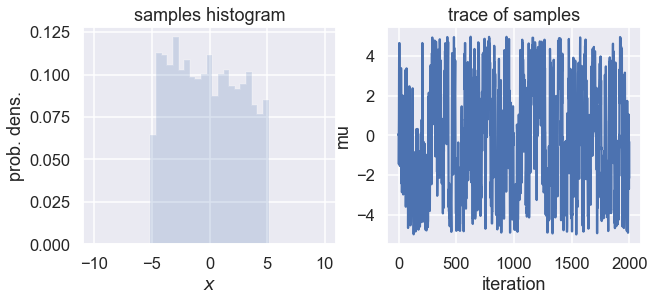

In [4]:
# for reproducibility
np.random.seed(13)
samples = sampler(0.,no_of_samples=2000, proposal_width=2.)

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(10, 4))
ax1.hist(samples, density=True, histtype='stepfilled', alpha=0.2, 
         range=(-10,10),bins=41)
ax1.set(xlabel=r'$x$', ylabel='prob. dens.', title='samples histogram')
ax2.plot(samples)
ax2.set(xlabel='iteration', ylabel='mu', title='trace of samples');

### Questions

* What distribution does the probability density as represented by the histogram resemble?
* You can try increasing or decreasing the number of samples.
* Study the algorithm closely and find the line where the current position is added again to the list of samples if the proposed position is outside the hard-wall boundary. What happens if you change this so that the proposed step is just ignored and no position gets added to the list of samples for that iteration? 
* What happens if you try with another proposal distribution, e.g. a uniform one?
* What happens if you decrease the width of the proposal distribution?

When answering the last question you probably did find that the proposal changed quite drastically when using the same number of samples, but taking much shorter steps. This is a consequence of the collected samples being *correlated*. 

We can define the autocorrelation function $\rho(h)$ from the list of samples $X$, where $X_t$ is sample $t$ and $X_{t+h}$ is a shifted version of $X_t$ with $h$ being called the *lag*
$$
\rho(h) = \frac{\sum_\mathrm{overlap} \left[ (X_t - \bar{X}) (X_{t+h} - \bar{X})\right]}
{\sqrt{ \sum_\mathrm{overlap} (X_t - \bar{X})^2 } \sqrt{ \sum_\mathrm{overlap} (X_{t+h} - \bar{X})^2 }}
$$
The summation is carried out over the subset of samples that overlap.

In [5]:
def autocorrelation(chain, max_lag=100):
    dimension = len(chain)
    acors = np.empty(max_lag+1)
    if max_lag > len(chain)/5:
        warnings.warn('max_lag is more than one fifth the chain length')
    # Create a copy of the chain with average zero
    chain1d = chain - np.average(chain)
    for lag in range(max_lag+1):
        unshifted = None
        shifted = chain1d[lag:]
        if 0 == lag:
            unshifted = chain1d
        else:
            unshifted = chain1d[:-lag]
        normalization = np.sqrt(np.dot(unshifted, unshifted))
        normalization *= np.sqrt(np.dot(shifted, shifted))
        acors[lag] = np.dot(unshifted, shifted) / normalization
    return acors

Study the behavior of the autocorrelation function (ACF) $\rho(h)$ 
* First, take a minute to get a feeling for the definition of the ACF. Try to describe the operation that is performed in words.
* What happens when the proposal width is large/small/intermediate?
* What does it mean when the autocorrelation is large/small?
* It is often observed that $\rho(h)$ is roughly exponential so that we can define an autocorrelation time $\tau$ according to
$$
\rho(h) \sim \exp(-h/\tau).
$$
Extract $\tau$ for some different choices of the proposal width.

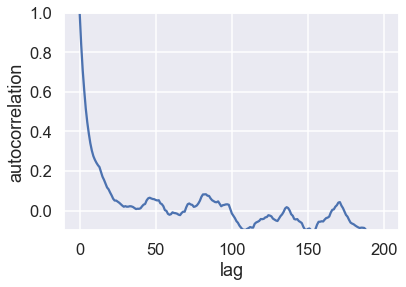

In [6]:
acors = autocorrelation(samples,max_lag=200)
fig, ax = plt.subplots()
ax.plot(acors);
ax.set(xlabel='lag', ylabel='autocorrelation', ylim=(-.1, 1));

## Part 2: MCMC sampling of a Lorentzian pdf using the random walk Metropolis algorithm

In the previous example we performed a random walk and accepted all steps unless they were outside a hard-wall boundary. This corresponds to a situation where all positions within that region is equally probable, and all positions outside have probability zero. 

* What pdf does that situation correspond to?

Now, let us try another situation in which we have some function that tells us the (possibly unnormalized) probability of a given position. We will assume a known, specific form of this pdf, namely a Lorentzian (Cauchy) distribution, but it might just as well be some very complicated function that can only be evaluated numerically. All that is needed is some function that, for each position in the parameter space, returns a probability.

Let us start by studying the pdf that we will be sampling from using a random walk (using the Metropolis algorithm outlined below). 

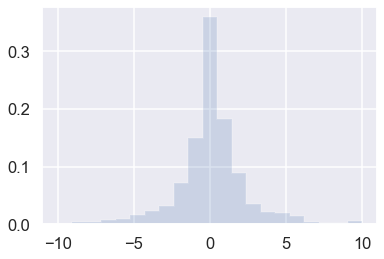

In [7]:
# Draw a number of random samples from the standard Cauchy
r = cauchy.rvs(size=1000)
plt.hist(r, density=True, histtype='stepfilled', alpha=0.2, 
         range=(-10,10),bins=21);

### Questions:
This histogram corresponds to a finite sample from the pdf of a standard Cauchy (Lorentzian)
$$ 
p(x | \alpha=0, \beta=1) = \frac{1}{\pi(1+x^2)}, 
$$
with mean $\alpha=0$ and FWHM $2\beta = 2$.

- How does this pdf compare with a standard normal distribution $\mathcal{N}(x;\mu=0,\sigma^2=1)$?
- What is the function of the optional argument 'density=True' in the 'hist' plot function call in the cell above?
- What happens if you remove the optional 'range' and 'bins' arguments from the 'hist' plot function call in the cell above?
- Why? How would this look when plotting a histogram for random samples from a standard normal distribution? 

Let us turn the posterior into a callable function. We will deliberately remove the normalization to make the point that sampling can be made for an unnormalized pdf:

In [8]:
def posterior_function(x):
    return 1 / (1+x**2)

def normalized_posterior_function(x):
    return 1 / (np.pi * (1+x**2))

Now on to the sampling. At first, you define the starting parameter position (can be randomly chosen), let's fix it arbitrarily to:

```python
current_position = 1.
```

Then, you propose to move (jump) from that position somewhere else (that's the Markov part). You can be very dumb or very sophisticated about how you come up with that proposal. The Metropolis sampler is very dumb and just takes a sample from a proposal distribution (here we again choose a normal distribution) centered around your current position (i.e. `current_position`) with a certain standard deviation (`proposal_width`) that will determine how far you propose jumps (here we're using `scipy.stats.norm`):

```python
proposal_position = norm(current_position, proposal_width).rvs()
```

Next, you evaluate whether that's a good place to jump to or not. We quantify this by computing the probability of the proposed position in parameter space, i.e. evaluating the posterior pdf at the proposed position. Usually you would use log probabilities but we omit this here.

```python
# Nominator of Bayes' formula
p_current = posterior(current_position)
p_proposal = posterior(proposed_position)

```

Up until now, we essentially have a hill-climbing algorithm that would just propose movements into random directions and only accept a jump if the `proposed_position` has higher likelihood than `current_position`. Eventually we'll get to `x = 0` (or close to it) from where no more moves will be possible. However, we want to get a posterior pdf so we'll also have to sometimes accept moves into the other direction. The key trick is by dividing the two probabilities,

```python
p_accept = p_proposal / p_current
```

we get an acceptance probability. Note that the acceptance probability is obtained by dividing the posterior of proposed parameter setting by the posterior of the current parameter setting. This implies that the posterior pdf does not necessarily need to be normalized, the normalization factor will anyway be canceled out. 

You can see that if `p_proposal` is larger, that probability will be `> 1` and we'll definitely accept. However, if `p_current` is larger, say twice as large, there'll be a 50% chance of moving there which we will decide by drawing a random number:

```python
accept = np.random.rand() < p_accept

if accept:
    # Update position
    current_position = proposed_position

```

This simple procedure gives us samples from the posterior.

In [9]:
def sampler(posterior_func, no_of_samples=4, start_position=.5, 
            proposal_width=1., plot=False):
    current_position = start_position
    samples = [current_position]
    for i in range(no_of_samples):
        # suggest new position
        proposed_position = norm(current_position, proposal_width).rvs()

        # Compute posteriors of current and proposed position       
        p_current = posterior_func(current_position)
        p_proposal = posterior_func(proposed_position) 
        
        # Acceptance probability
        # Note that this part will be modified in the Metropolis-Hastings algorithm 
        # for which we also consider asymmetric proposal distributions
        p_accept = p_proposal / p_current
        
        # Accept proposal?
        accept = np.random.rand() < p_accept
        
        # Visualization
        if plot:
            assert no_of_samples < 11, "Too many samples for visualization"
            plot_proposal(posterior_func, current_position, p_current, 
                          proposed_position, p_proposal, accept, samples, i)
        
        if accept:
            # Update position
            current_position = proposed_position
        
        samples.append(current_position)
        
    return np.array(samples)

# Function to display
def plot_proposal(posterior_func, current_position, p_current, 
                  proposed_position, p_proposal, accepted, trace, i):
    from copy import copy
    trace = copy(trace)
    fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, figsize=(12, 4))
    fig.suptitle('Iteration %i' % (i + 1))
    x = np.linspace(-5, 5, 5000)
    color = 'g' if accepted else 'r'
        
    # Plot posterior
    ax1.plot(x, posterior_func(x))
    ax1.plot([current_position] * 2, [0, p_current], marker='o', color='b')
    ax1.plot([proposed_position] * 2, [0, p_proposal], marker='o', color=color)
    ax1.annotate("", xy=(proposed_position, 0.2), xytext=(current_position, 0.2),
                 arrowprops=dict(arrowstyle="->", lw=2.))
    ax1.set(ylabel='Probability Density', \
            title='current: posterior(mu=%.2f) = %.2f\nproposal: posterior(mu=%.2f) = %.2f' \
            % (current_position, p_current, proposed_position, p_proposal))
    
    if accepted:
        trace.append(proposed_position)
    else:
        trace.append(current_position)
        
    # Posterior histogram
    ax2.plot(x, normalized_posterior_function(x)) # properly normalized
    sns.distplot(trace, kde=False, norm_hist=True, ax=ax2)
    ax2.axvline(current_position, color='b', linestyle='--', 
                label='current position')
    ax2.axvline(proposed_position, color=color, linestyle='--', 
                label='proposed position')
    ax2.annotate("", xy=(proposed_position, 0.2), xytext=(current_position, 0.2),
                 arrowprops=dict(arrowstyle="->", lw=2.))

    
    ax3.plot(trace)
    ax3.set(xlabel='iteration', ylabel='position', title='trace')
    plt.tight_layout()

To visualize the sampling, we'll create plots for some quantities that are computed. Each row below is a single iteration through our Metropolis sampler. 

The first column displays our unnormalized posterior distribution. This is for visualization only, normally we would not be able to plot a nice curve to show the posterior. Here, we plug in our $x$ proposals. The vertical lines represent our current position in blue and our proposed position in either red or green (rejected or accepted, respectively). 

The second column is our posterior distribution. Here we are displaying the normalized posterior as the blue curve compared to the normalized histogram of samples (green bars) and the move that was just proposed.

The third column is our trace (i.e. the posterior samples of visited positions that we're generating). Note that we store a sample at each iteration, irrespective of whether the propsal was accepted or rejected. In the latter situation, we keep the previous position and the line just stays constant.

Note that we always accept moves to relatively more likely $x$ values (in terms of their posterior density), but only sometimes to relatively less likely $x$ values, as can be seen already in the first iteration, and later in iterations 6, 7, and 8 (the iteration number can be found at the top center of each row).

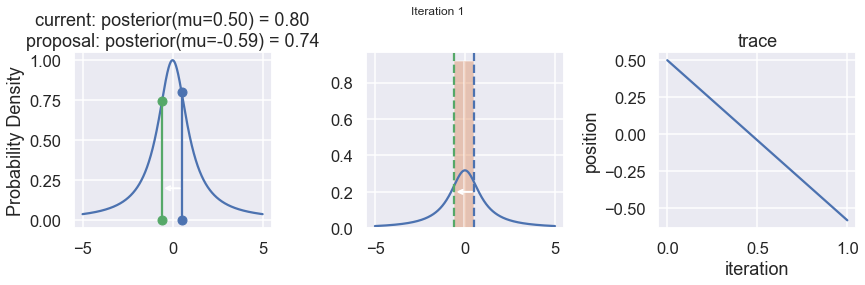

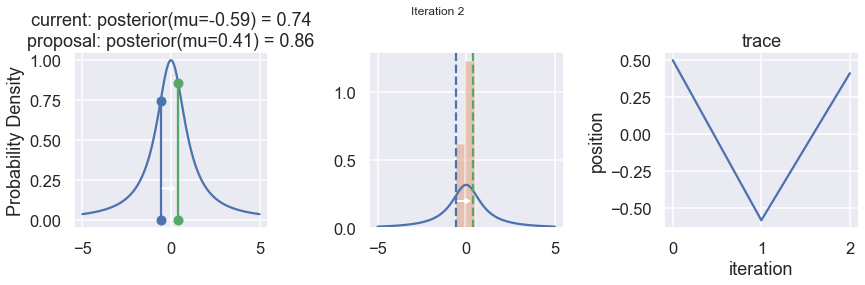

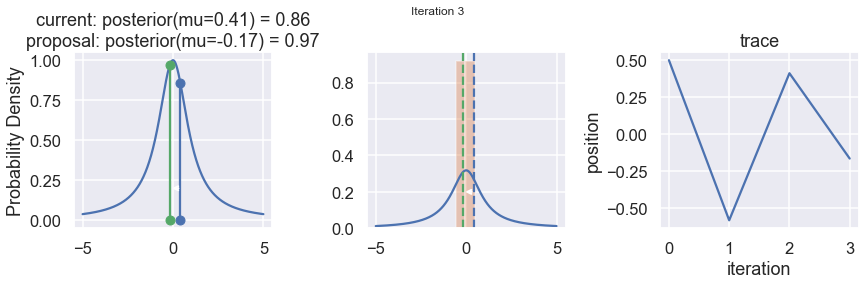

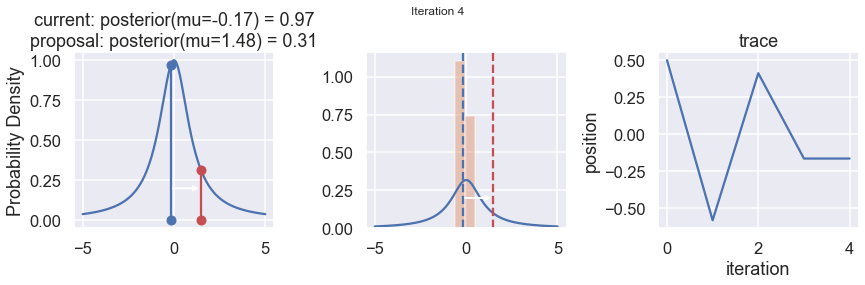

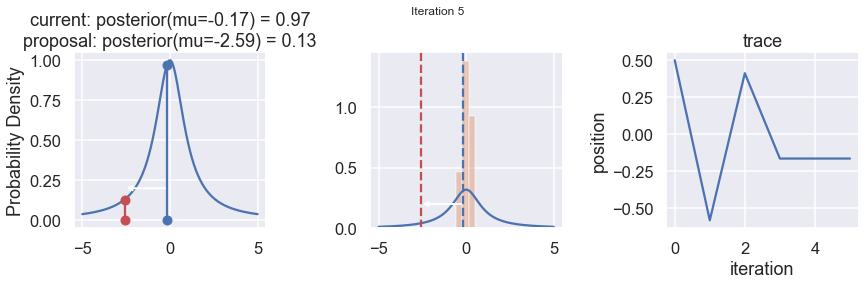

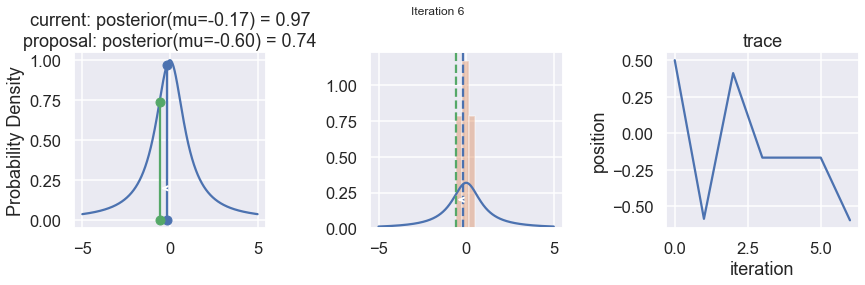

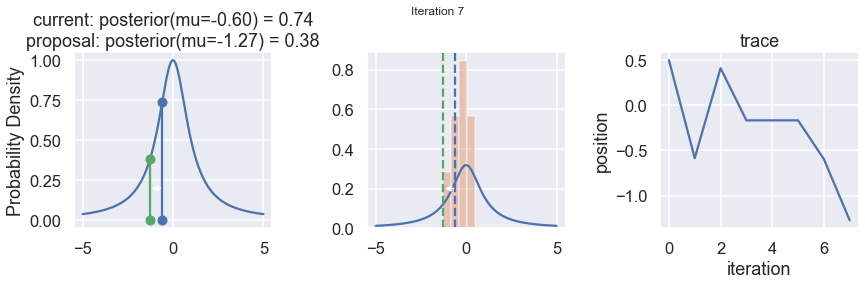

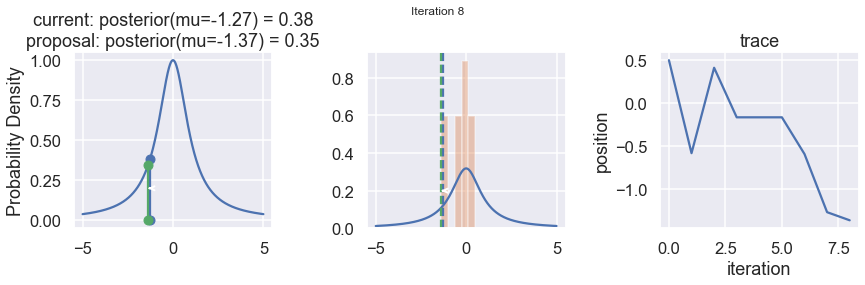

In [10]:
np.random.seed(123)
samples = sampler(posterior_function, no_of_samples=8, start_position=.5, proposal_width=1., plot=True);

Now the magic of MCMC is that you just have to do that for a long time, and the samples that are generated in this way come from the posterior distribution of your model. There is a rigorous mathematical proof that guarantees this, which we won't go into detail here.

To get a sense of what this produces, lets draw a lot of samples and plot them.

In [11]:
samples = sampler(posterior_function, no_of_samples=15000, start_position=1.)

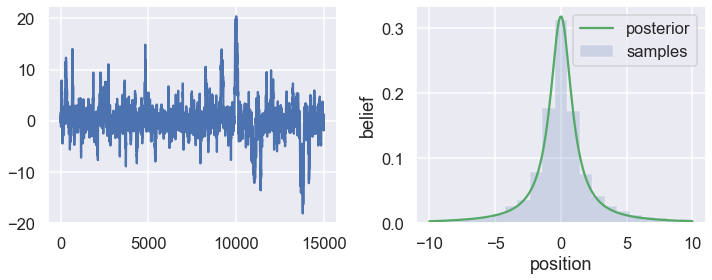

In [12]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(10, 4))

ax1.plot(samples)
ax.set(xlabel='sample', ylabel='x');

ax2.hist(samples[500:], density=True, histtype='stepfilled', alpha=0.2, 
         range=(-10,10), bins=21, label='samples')
x = np.linspace(-10., 10., 200)
ax2.plot(x, normalized_posterior_function(x), 'g', label='posterior')
ax2.set(xlabel='position', ylabel='belief');
ax2.legend();
plt.tight_layout()

The plot in the left panel is usually called the trace. To get an approximation of the posterior (the reason why we're doing all this), we simply take the histogram of this trace. That histogram is shown in the right panel which then represents our **belief** in the probability density for different `positions`. For comparison we also show (green line) the properly normalized posterior pdf, for which we had a known analytical form in this case.

### Questions / tasks
* Add functionality to extract the acceptance rate (i.e. the fraction of proposed steps that are accepted).
* Print the acceptance rate and plot the autocorrelation function / autocorrelation time when performing the following studies:
* Based mainly on empirical studies, Roberts, Gelman, and Gilks (1997) recommend calibrating the acceptance rate to about 25% for a high-dimensional model, and to about 50% for models of one or two dimensions. How can you calibrate the acceptance rate of your MCMC sampler?
* Try to sample from some other posterior pdf.
* What happens when you change the proposal distribution: 
    * Using a different proposal distribution?
    * What happens if you make it asymmetric around the 'current_position'?
    * What happens if you stick to the normal distribution as a proposal distribution, but change its width?
* How would you define that a MCMC algorithm works? What is the property that you are after?
* The Metropolis algorithm works because it has three properties:
    * It is _irreducible_
    * It is _aperiodic_
    * It is _positive recurrent_
    
  What do you think that these properties mean?


### Optional task: log probabilities
Since one often encounters very small probabilities when sampling from some pdf it is usually a good idea to work with log probabilities instead.
* Modify the code above to employ log-probabilities instead.

## Part 3: Detailed balance and the Metropolis-Hastings algorithm

### Questions / tasks
* Write an expression for the Metropolis acceptance probability, $\alpha(X_t, X_{t+1})$, that describes the probability of accepting a proposed step from $X_t$ to $X_{t+1}$. Use the notation $p(X_t | D, I)$ for the probability of drawing sample $X_t$ from the posterior and analogous for $p(X_{t+1} | D, I)$.

Let us introduce the notation $q(X_{t+1} | X_t)$ for the probability (pdf) for proposing a step from position $X_t$ to $X_{t+1}$.
* What does $q(X_{t+1} | X_t)$ correspond to in the above example?

From these two quantities, $q(X_{t+1} | X_t)$ and $\alpha(X_t, X_{t+1})$, it is possible to define a transition kernel
$$
p(X_{t+1}|X_t) = q(X_{t+1} | X_t) \alpha(X_t, X_{t+1})
$$
* Why do you think that is called a _transition kernel_?

Our definition of the acceptance probability implies _detailed balance_
$$
p(X_t | D, I) p(X_{t+1}|X_t) = p(X_{t+1} | D, I) p(X_t|X_{t+1}),
$$
* Why do you think that this property is called detailed balance? Can you make an analogy with thermodynamic equilibrium for e.g. a collection of hydrogen atoms?

In this exercise we have considered the Metropolis algorithm, proposed by Metropolis _et al._ in 1953. Hastings (1970) generalized the algorithm to include asymmetric proposal distributions. The single consequence of this generalization is a modification of the acceptance probability $\alpha(X_t, X_{t+1})$.
* How is the acceptance probability $\alpha(X_t, X_{t+1})$ modified when allowing for asymmetric proposal distributions?
* Try to make this change in the code above and try with both symmetric and asymmetric proposal distributions. For an asymmetric proposal distribution you could use a log normal pdf (which is available from scipy.stats).